In [1]:
%matplotlib inline

from functools import partial
from pprint import pprint
import random
from collections import deque
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet50
from torch.utils.data import DataLoader
from torch import nn, optim
import wids

In [2]:
# parameters
epochs = 3
max_steps = 100000
batch_size = 32
bucket = "https://storage.googleapis.com/webdataset/fake-imagenet/"
num_workers = 4
cache_dir = "./_cache"

In [3]:
# Parameters
max_steps = 10000


In [4]:
# helpers

import time


def enumerate_report(seq, delta, growth=1.0):
    last = 0
    count = 0
    for count, item in enumerate(seq):
        now = time.time()
        if now - last > delta:
            last = now
            yield count, item, True
        else:
            yield count, item, False
        delta *= growth

In [5]:
# The standard TorchVision transformations.

transform_train = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# The dataset returns dictionaries. This is a small function we transform it
# with to get the augmented image and the label.


def make_sample(sample, val=False):
    image = sample[".jpg"]
    label = sample[".cls"]
    if val:
        return transform_val(image), label
    else:
        return transform_train(image), label

In [6]:
# These are standard PyTorch datasets. Download is incremental into the cache.

trainset = wids.ShardListDataset(
    bucket+"imagenet-train.json", cache_dir=cache_dir, keep=True
)
valset = wids.ShardListDataset(
    bucket+"imagenet-val.json", cache_dir=cache_dir, keep=True
)

trainset[0]

https://storage.googleapis.com/webdataset/fake-ima base: https://storage.googleapis.com/webdataset/fake-imagenet name: imagenet-train nfiles: 1282 nbytes: 31242280960 samples: 128200 cache: ./_cache


https://storage.googleapis.com/webdataset/fake-ima base: https://storage.googleapis.com/webdataset/fake-imagenet name: imagenet-val nfiles: 50 nbytes: 1219143680 samples: 5000 cache: ./_cache


{'.cls': 6,
 '.jpg': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 '.txt': 'a high quality color photograph of a lion',
 '__key__': '000000-000003',
 '__dataset__': None,
 '__index__': 0,
 '__shard__': 'https://storage.googleapis.com/webdataset/fake-imagenet/imagenet-train-000000.tar',
 '__shardindex__': 0}

In [7]:
# Next, we add the transformation to the dataset. Transformations
# are executed in sequence. In fact, by default, there is a transformation
# that reads and decodes images.

trainset.add_transform(make_sample)
valset.add_transform(partial(make_sample, val=True))

print(trainset[0][0].shape, trainset[0][1])

torch.Size([3, 224, 224]) 6


/home/tmb/proj/webdataset/wids/wids.py:740: UserWarning: DistributedChunkedSampler is called without distributed initialized; assuming single process
  warnings.warn(


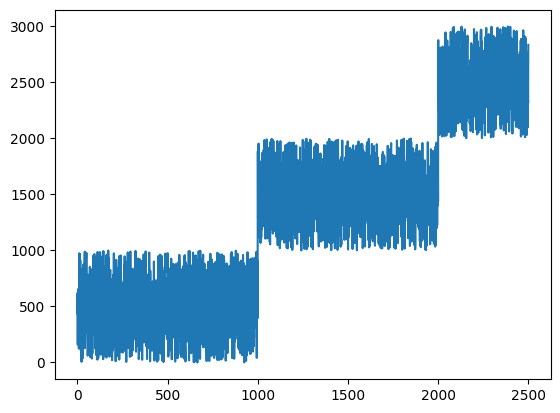

In [8]:
# We also need a sampler for the training set. There are three
# special samplers in the `wids` package that work particularly
# well with sharded datasets:
# - `wids.ShardedSampler` shuffles shards and then samples in shards;
#   it guarantees that only one shard is used at a time
# - `wids.ChunkedSampler` samples by fixed sized chunks, shuffles
#   the chunks, and the the samples within each chunk
# - `wids.DistributedChunkedSampler` is like `ChunkedSampler` but
#   works with distributed training (it first divides the entire
#   dataset into per-node chunks, then the per-node chunks into
#   smaller chunks, then shuffles the smaller chunks)

# trainsampler = wids.ShardedSampler(trainset)
# trainsampler = wids.ChunkedSampler(trainset, chunksize=1000, shuffle=True)
trainsampler = wids.DistributedChunkedSampler(trainset, chunksize=1000, shuffle=True)

plt.plot(list(trainsampler)[:2500])

# Note that the sampler shuffles within each shard before moving on to
# the next shard. Furthermore, on the first epoch, the sampler
# uses the shards in order, but on subsequent epochs, it shuffles
# them. This makes testing and debugging easier. If you don't like
# this behavior, you can use shufflefirst=True

trainsampler.set_epoch(0)

In [9]:
# Create data loaders for the training and validation datasets

trainloader = DataLoader(trainset, batch_size=batch_size, num_workers=4, sampler=trainsampler)
valloader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=4)

images, classes = next(iter(trainloader))
print(images.shape, classes.shape)

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [10]:
# The usual PyTorch model definition. We use an uninitialized ResNet50 model.

model = resnet50(pretrained=False)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/tmb/proj/webdataset/venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
losses, accuracies = deque(maxlen=100), deque(maxlen=100)

steps = 0

# Train the model
for epoch in range(epochs):
    for i, data, verbose in enumerate_report(trainloader, 5):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        pred = outputs.cpu().detach().argmax(dim=1, keepdim=True)
        correct = pred.eq(labels.cpu().view_as(pred)).sum().item()
        accuracy = correct / float(len(labels))

        losses.append(loss.item())
        accuracies.append(accuracy)
        steps += len(labels)

        if verbose and len(losses) > 5:
            print(
                "[%d, %5d] loss: %.5f correct: %.5f"
                % (epoch + 1, i + 1, np.mean(losses), np.mean(accuracies))
            )
            running_loss = 0.0

        if steps > max_steps:
            break
    if steps > max_steps:
        break

print("Finished Training")

[1,    18] loss: 4.92214 correct: 0.06597


[1,    44] loss: 4.47568 correct: 0.07315


[1,    70] loss: 4.05072 correct: 0.09420


[1,    95] loss: 3.76577 correct: 0.11086


[1,   120] loss: 3.29646 correct: 0.14625


[1,   146] loss: 2.90517 correct: 0.18688


[1,   171] loss: 2.69376 correct: 0.21656


[1,   196] loss: 2.50486 correct: 0.26656


[1,   221] loss: 2.35720 correct: 0.30719


[1,   246] loss: 2.22152 correct: 0.34719


[1,   271] loss: 2.09821 correct: 0.38562


[1,   296] loss: 2.01367 correct: 0.39969


Finished Training
